In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import random 
import math
import collections
import re
import time
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Reading data

In [3]:
#read alphabet
alphabet = pd.read_csv('alphabet.csv')
alphabet = np.array(alphabet.columns)

In [4]:
#read chiper_function
cipher_function  = pd.read_csv('cipher_function.csv')
cipher_function = np.array(cipher_function.columns)

In [5]:
#create MAP table for chiper_function // chiper_letter --> original letter
cipher_MAP = pd.DataFrame(cipher_function,alphabet)
cipher_MAP.columns = ['ciphing']

In [6]:
#read cipher_text
cipher_file = open('ciphertext.txt','r')
cipher_text = cipher_file.read()
cipher_file.close()

In [7]:
#read letter_probs
letter_probs = pd.read_csv('letter_probabilities.csv')
letter_probs = np.array(letter_probs.columns)

In [8]:
#read letter_transition_matrix 
trans_mat = pd.read_csv('letter_transition_matrix.csv', header=None)
trans_mat = np.array(trans_mat)

In [9]:
#read plain(original) text
plain_file = open('plaintext.txt','r')
plain_text = plain_file.read()
plain_file.close()

# Problem 1: Bayesian Framework

- (a) Determine the likelihood of the (observed) ciphertext y under a ciphering func-
tion f, i.e., $ p_{y|f} (y | f).$

$ p_{y|f} (y | f) = \frac{p(y,f)} {p(f)} $

- (b) Determine  the posterior distribution $ p_{f|y}(f | y) $  and specify the MAP estimator $ \hat{f}_{MAP}(y)$ of the  ciphering function f . 

$ p_{f|y} (f | y) = p(f^{-1}(y_0)) \displaystyle\prod_{n = 2}^{N} p(y_n|y_{n-1}(f^{-1}(y_n)|f^{-1}(y_{n-1}))) $           
$\hat{f}_{MAP}(y)$ is a estimator of chip_function, for which $ E_p[\hat{f}_{MAP}(y)] = f$ 

- (c) Why is direct evaluation of the MAP estimate $ \hat{f}_{MAP}(y)$ computationally infeasible?

To find out $ p_{f|y} (f | y) $ we need calculate $p(y)$ marginal distribution, which can be represented directly by this formula
$$ p(Y = y) =  \sum_f p(Y = y| F = f) p(F = f) $$
Here F is a random function which represented ciphering function f .
The number of f's is so large...if the map is one-to-one then there is 28!=3e29+  different f's and therefore it's infeasible to calculate

# Problem 2: Markov Chain Monte Carlo Method

- (a) Modeling the ciphering function f as uniformly distributed over the set of permutations of symbols from $A$, find the probability that two ciphering functions f1 and f2 differ in exactly two symbol assignments.

$$ Pr(dist(f_1,f_2) = 2) = \frac{ |\{(f_1, f_2) | dist(f_1,f_2) = 2\}|}{ |{(f_1,f_2) }|} = \frac{26!C_{28}^2C_{28}^2 2!}{28! 28!} = \frac{1}{2*26!} $$

- 
(b) Using the Metropolis-Hastings algorithm, construct a Markov chain whose stationary distribution is the posterior found in Problem 1(b).

Hint: Use Problem 2(a) for constructing a proposal distribution.

- (c) Fully specify the MCMC based decoding algorithm, in the form of pseudo-code.

# Problem 3: Implementation

In [10]:
#find space
space = collections.Counter(cipher_text).most_common(1)[0][0]
#find endpoint
used = set()
endpoint = '.'
for i in range(len(alphabet)):
    p = True
    if alphabet[i] not in used:
        matches = re.findall(r'{}[a-z]'.format(alphabet[i]),cipher_text)
        for item in matches:
            if item[1] != space:
                used.add(item[0])
                p = False
                break
    if p == True:
        endpoint = alphabet[i]
        break

In [11]:
def create_cipher_dict(cipher):
    '''
    param  <cipher>      - string i.g "aertyko...."
    return <cipher_dict> - maping dict {'a':'a','b':'e','c':'r','d':'t','e':'y','f':'k','g':'o',...}
    '''
    cipher_dict = {}
    for i in range(len(cipher)):
        cipher_dict[cipher[i]] = alphabet[i]
    
    return cipher_dict

In [12]:
def apply_cipher_on_text(text,cipher):
    '''
    param <text> - any string 
    param <cipher> - encoding function /type(cipher) = str
    '''
    cipher_dict = create_cipher_dict(cipher) 
    text = list(text)
    newtext = ""
    for elem in text:
        if elem.lower() in cipher_dict:
            newtext += cipher_dict[elem.lower()]
        else:
            newtext += " "
    
    return newtext

In [13]:
def convert_letter(letter):
    '''
    param <letter> -- simple character
    return <int> -- corespond number in alphabet
    '''
    if letter == ' ':
        return 26
    if letter == '.':
        return 27
    if letter.isupper():
        return ord(letter) - 65
    return ord(letter) - 97

In [14]:
def log_posterior_probability(cipher_text,trans_mat, f):
    cipher_indices_map = {}
    for i, fi  in enumerate(f):
        cipher_indices_map[fi] = i
    init_index = cipher_indices_map[cipher_text[0]]

    init_log_p = np.log(float(letter_probs[init_index]))
    curr_index = init_index
    probs = np.empty(len(cipher_text)-1)
    for i in range(1, len(cipher_text)):
        if cipher_text[i] == '\n':
            continue
        next_index = cipher_indices_map[cipher_text[i]]
        if trans_mat[next_index, curr_index] == 0:
            return -np.inf
        probs[i-1] = trans_mat[next_index, curr_index]
        curr_index = next_index
        
    log_probs = np.log(probs)
    log_probs[np.isnan(log_probs)] = 0
    
    return float(log_probs.sum() + init_log_p)

In [15]:
def generate_cipher(cipher):
    pos1 = random.randint(0, len(list(cipher))-3)
    pos2 = random.randint(0, len(list(cipher))-3)

    if pos1 == pos2:
        return generate_cipher(cipher)
    
    cipher = list(cipher)
    pos1_alpha = cipher[pos1]
    pos2_alpha = cipher[pos2]
    cipher[pos1] = pos2_alpha
    cipher[pos2] = pos1_alpha
    return correct_cipher(''.join(cipher))
            

In [16]:
def correct_cipher(cipher):
    #replace spaces
    cp = list(cipher)
    sp = cp.index(space)
    cp[sp] = cp[-2]
    cp[-2] = space
    #replace endpoint
    sp = cp.index(endpoint)
    cp[sp] = cp[-1]
    cp[-1] = endpoint
    return ''.join(cp)

In [17]:
def random_coin(p):
    unif = random.uniform(0,1)
    if unif>=p:
        return False
    return True

In [90]:
def init_cipher_function(cipher_text, scoring_params,max_iter = 1000):
    
    for i in range(max_iter):
        init_state = ''.join(random.sample(list(alphabet),len(alphabet)))
        init_state = correct_cipher(init_state)
        if np.isfinite(log_posterior_probability(cipher_text,scoring_params,init_state)):
            print(log_posterior_probability(cipher_text,scoring_params,init_state))
            return init_state
    

In [92]:
init_state = init_cipher_function(cipher_text,trans_mat)
print(init_state)

-157307.11264553573
snifhubrmwqxkv gedtzlpca.oyj


In [93]:
def MCMC_decrypt(n_iter,cipher_text,scoring_params):
    
    current_cipher = init_state
    best_state = ''
    score = -np.inf
    log_probs_history = []
    for i in range(n_iter):
        
        
        proposed_cipher = generate_cipher(current_cipher)        

        score_current_cipher  = log_posterior_probability(cipher_text,scoring_params,current_cipher)
        score_proposed_cipher = log_posterior_probability(cipher_text,scoring_params,proposed_cipher)
        acceptance_probability = min(1,np.exp(score_proposed_cipher-score_current_cipher))
        log_probs_history.append(score_proposed_cipher)
        if score_current_cipher>score:
            best_state = current_cipher
            score = score_current_cipher 
        if random_coin(acceptance_probability):
            current_cipher = proposed_cipher

        if i%100 == 0:
            print ("iter",i,":",apply_cipher_on_text(cipher_text,best_state)[0:99])
    return best_state,log_probs_history

In [94]:
start = time.time()
best_state,score_history = MCMC_decrypt(3000,cipher_text,trans_mat)
print(time.time() - start)

iter 0 : zh xgrpxv ly gsgxu qyxt yq cetph pwlzszlu zl zo hgwgoopxu lcpl lcg iegolzyh ocyebv ag pomgv qxyt lz
iter 100 : it nevdnk oa exenf manl am ruldt dpoixiof io is tepessdnf ordo ore quesoiat srauhk ce dsyek mnal oi
iter 200 : id nekonm ta ecenf yanp ay hupod olticitf it is delessonf thot the questiad shaurm be osvem ynap ti
iter 300 : in mekomy ta ecemf damp ad hupon orticitf it is neressomf thot the questian shauly be osvey dmap ti
iter 400 : in mekamd to ecemf yomp oy hupan articitf it is neressamf that the question should be asved ymop ti
iter 500 : in mekamd to ecemf yomp oy hupan asticitf it ir neserramf that the quertion rhould be arved ymop ti
iter 600 : in mekamd to ecemf yomp oy hupan asticitf it ir neserramf that the quertion rhould be arved ymop ti
iter 700 : in mecamd to ekemf yomp oy hupan astikitf it ir neserramf that the quertion rhould be arved ymop ti
iter 800 : in mecamd to ekemf yomp oy hupan astikitf it ir neserramf that the quertion rhould be arved ymop ti
ite

In [95]:
def accurancy(text, decoded_text):
    sum = 0 
    for ch1,ch2 in zip(text,decoded_text):
        if ch1 == ch2:
            sum += 1
    return sum,len(text),sum/len(text)

In [96]:
accurancy(best_state,''.join(cipher_function))

(28, 28, 1.0)

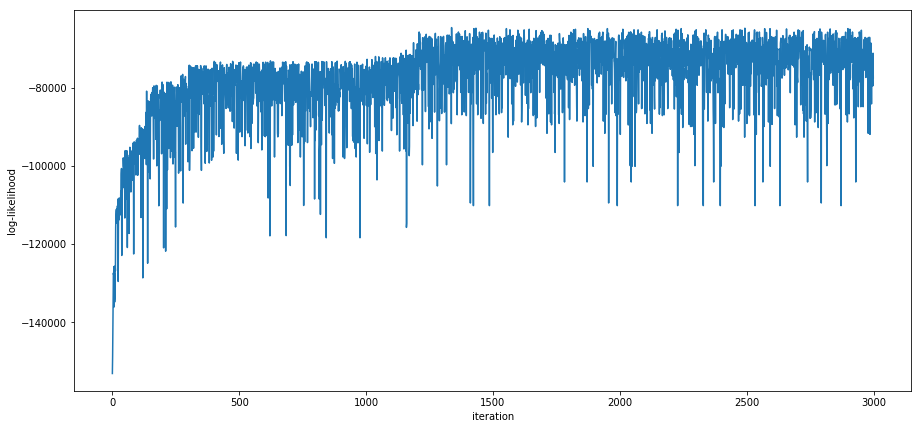

In [103]:
plt.figure(figsize = (15,7))
plt.plot(score_history)
plt.xlabel('iteration')
plt.ylabel('log-likelihood')